<a href="https://colab.research.google.com/github/zacharylazzara/tent-detection/blob/main/Tent_Detector_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Initialization

##Config

In [20]:
N_EPOCHS      = 200
BATCH_SIZE    = 8
INIT_LR       = 0.0001
IMAGE_HEIGHT  = 512
IMAGE_WIDTH   = 512
TEST_SPLIT    = 0.15
U_MODEL_NAME  = 'unet.pth'
C_MODEL_NAME  = 'cnn.pth'
OUTPUT_FORMAT = 'png'

##Imports

In [21]:
!pip install torchmetrics -q
import os
import csv
import cv2
import torch
import pandas as pd
import matplotlib.pyplot as plt
from statistics import mean
from tqdm import tqdm
from pathlib import Path
from sklearn.model_selection import train_test_split
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch.nn import Sequential
from torch.nn import ModuleList
from torch.nn import ConvTranspose2d
from torch.nn import Flatten
from torch.nn import functional
from torch.nn import BatchNorm2d
from torch.nn.modules.loss import BCEWithLogitsLoss
from torch.nn.modules.loss import PoissonNLLLoss
from torchmetrics.classification import BinaryJaccardIndex
from torch import flatten
from torch import cat
from torch import randn
from torchvision import transforms
from torchvision.transforms import CenterCrop
from torchvision.utils import save_image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.optim import SGD
import torchvision.transforms.functional as TF

##Environment

In [22]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
PIN_MEMORY = True if DEVICE == "cuda" else False
print(f'Using device: {DEVICE}')

Using device: cuda


In [23]:
# Initialize Environment
%env SRC_DIR        = sarpol-zahab-tents
%env OUTPUT_DIR     = output

SRC_DIR             = os.environ.get('SRC_DIR')
OUTPUT_DIR          = os.environ.get('OUTPUT_DIR')

DATA_PATH           = Path(f'{SRC_DIR}/data')
IMAGES_PATH         = Path(f'{DATA_PATH}/images')
MASKS_PATH          = Path(f'{DATA_PATH}/labels')
LABELS_PATH         = Path(f'{DATA_PATH}/sarpol_counts.csv')
EXT                 = '*.jpg'

env: SRC_DIR=sarpol-zahab-tents
env: OUTPUT_DIR=output


In [24]:
# Initialize Directories
%%bash

if [ -d 'sample_data' ]; then
  rm -r sample_data
fi

if [ ! -d $SRC_DIR ]; then
  git clone https://github.com/tofighi/sarpol-zahab-tents.git
fi

if [ ! -d $OUTPUT_DIR ]; then
  mkdir -p $OUTPUT_DIR
fi

#Models

##UNet
Adapted from: https://pyimagesearch.com/2021/11/08/u-net-training-image-segmentation-models-in-pytorch/

In [25]:
# Adapted from: https://pyimagesearch.com/2021/11/08/u-net-training-image-segmentation-models-in-pytorch/

class Block(Module):
  def __init__(self, in_channels, out_channels):
    super(Block, self).__init__()
    self.double_conv2d = Sequential(
        Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
        BatchNorm2d(out_channels),
        ReLU(inplace=True),
        Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
        BatchNorm2d(out_channels),
        ReLU(inplace=True)
    )

  def forward(self, x):
    return self.double_conv2d(x)

class Encoder(Module):
  def __init__(self, channels=(3, 16, 32, 64)):
    super(Encoder, self).__init__()
    self.encoder_blocks = ModuleList([Block(channels[i], channels[i+1]) for i in range(len(channels)-1)])
    self.pool = MaxPool2d(2)

  def forward(self, x):
    block_outputs = []
    for block in self.encoder_blocks:
      x = block(x)
      block_outputs.append(x)
      x = self.pool(x)
    return block_outputs

class Decoder(Module):
  def __init__(self, channels=(64, 32, 16)):
    super(Decoder, self).__init__()
    self.up_convs = ModuleList([ConvTranspose2d(channels[i], channels[i+1], 2, 2) for i in range(len(channels)-1)])
    self.decoder_blocks = ModuleList([Block(channels[i], channels[i+1]) for i in range(len(channels)-1)])
  
  def crop(self, encoder_features, x):
    (_, _, H, W) = x.shape
    return CenterCrop([H, W])(encoder_features)
  
  def forward(self, x, encoder_features):
    for i in range(len(self.up_convs)):
      x = self.up_convs[i](x)
      encoder_feature = self.crop(encoder_features[i], x)
      x = cat([x, encoder_feature], dim=1)
      x = self.decoder_blocks[i](x)
    return x

class UNet(Module):
  def __str__(self) -> str:
    return 'UNet'

  def __init__(self, encoder_channels=(3, 16, 32, 64), decoder_channels=(64, 32, 16), classes=1, retain_dim=True, output_size=(512, 512)):
    super(UNet, self).__init__()
    self.encoder = Encoder(encoder_channels)
    self.decoder = Decoder(decoder_channels)
    self.head = Conv2d(decoder_channels[-1], classes, 1)
    self.retain_dim = retain_dim
    self.output_size = output_size

  def forward(self, x):
    encoder_features = self.encoder(x)
    decoder_features = self.decoder(encoder_features[::-1][0], encoder_features[::-1][1:])
    map = self.head(decoder_features)
    if self.retain_dim:
      map = functional.interpolate(map, self.output_size)
    return map

##CNN

In [26]:
class CNN(Module):
  def __str__(self) -> str:
    return 'CNN'

  def __init__(self):
    super(CNN, self).__init__()
    self.model = Sequential(                # input:  3   x 512 x 512
        Conv2d(1, 64, 3),                   # output: 64  x 510 x 510 # TODO: change 1 to 3? or leave as 1? (depends on the input we use)
        ReLU(),                             #
        MaxPool2d(2),                       # output: 64  x 255 x 255
        Conv2d(64, 64, 3),                  # output: 64  x 253 x 253
        ReLU(),                             #
        MaxPool2d(2),                       # output: 64  x 126 x 126
        Flatten(),                          # output: 1016064
        Linear(1016064, 1),
        ReLU(),
        Linear(1, 1) # TODO: needs to be poisson output
    )

  def forward(self, x):
    return self.model(x).t().squeeze()

##Dataset

In [27]:
# Adapted from: https://pyimagesearch.com/2021/11/08/u-net-training-image-segmentation-models-in-pytorch/

class SegmentationDataset(Dataset):
  def __init__(self, dataframe, transformations = None):
    self.dataframe = dataframe
    self.transformations = transformations

  def __len__(self):
    return len(self.dataframe.index)

  def __getitem__(self, index):
    image = cv2.cvtColor(cv2.imread(self.dataframe.iloc[index]['image_paths']), cv2.COLOR_BGR2RGB)
    mask = cv2.threshold(cv2.imread(self.dataframe.iloc[index]['mask_paths'], cv2.IMREAD_GRAYSCALE), 150, 255, cv2.THRESH_BINARY)[1]
    if self.transformations is not None:
      image = self.transformations(image)
      mask = self.transformations(mask)
    return (image, mask, self.dataframe.iloc[index]['labels'], self.dataframe.index[index])

#Training and Evaluation Functions

##Training

In [28]:
# Adapted from: https://pyimagesearch.com/2021/11/08/u-net-training-image-segmentation-models-in-pytorch/

def train(model, t_loader, v_loader, loss_func, opt, metric=None, epochs=N_EPOCHS):
  history = pd.DataFrame({
      't': {'losses':[], 'metrics':[]},
      'v': {'losses':[], 'metrics':[]}
  })

  if metric != None:
    metric.to(DEVICE)

  loop = tqdm(range(epochs))
  for e in loop:
    model.train()
    losses = []
    for (i, (x, y, c, _)) in enumerate(t_loader):
      (x, y, c) = (x.to(DEVICE), y.to(DEVICE), c.to(DEVICE))
      feature = (y if str(model) == 'CNN' else x)
      target = (c if str(model) == 'CNN' else y)

      pred = model(feature)
      loss = loss_func(pred, target)
      losses.append(loss.item())

      if loss.requires_grad:
        opt.zero_grad()
        loss.backward()
      opt.step()

      if metric != None:
        metric.update(pred, target)
        
    history['t']['losses'].append(mean(losses))
    if metric != None:
      history['t']['metrics'].append(metric.compute().cpu().detach().numpy())
      metric.reset()
    
    with torch.no_grad():
      model.eval()
      
      losses = []
      for (x, y, c, _) in v_loader:
        (x, y, c) = (x.to(DEVICE), y.to(DEVICE), c.to(DEVICE))
        feature = (y if str(model) == 'CNN' else x)
        target = (c if str(model) == 'CNN' else y)

        pred = model(feature)
        loss = loss_func(pred, target)
        losses.append(loss.item())

        if metric != None:
          metric.update(pred, target)
      
      history['v']['losses'].append(mean(losses))
      if metric != None:
        history['v']['metrics'].append(metric.compute().cpu().detach().numpy())
        metric.reset()

    loop.set_description(f'E({e+1}/{N_EPOCHS}) Training {model}, Train Loss: {history["t"]["losses"][-1]:.4f}, Test Loss: {history["v"]["losses"][-1]:.4f}')
  return history

##Prediction

In [43]:
# TODO: remove y as we shouldn't need the ground truth for the prediction (we'll need
# to change the loader for the CNN however, as it should be using UNet's output)

def predict(model, loader):
  preds = pd.DataFrame({'names':[], 'image_paths':[], 'mask_paths':[], 'labels':[]}).set_index('names')
  with torch.no_grad():
    model.eval()
    for (epoch, (x, y, _, name)) in enumerate(loader):
      (x, y) = (x.to(DEVICE), y.to(DEVICE))
      feature = (y if str(model) == 'CNN' else x)
      pred = model(feature)

      if str(model) == 'CNN':
        for batch, c in enumerate(pred.cpu().detach()):
          preds.loc[name[batch]] = {'labels': c.numpy()}
      else:
        for batch, img in enumerate(pred.cpu().detach()):
          # Adapted from: https://discuss.pytorch.org/t/converting-tensors-to-images/99482/5
          img = torch.sigmoid(img)
          img = 1./(img.max()-img.min()) * img + 1.*img.min() / (img.min()-img.max())

          out_path = f'{OUTPUT_DIR}/{name[batch]}.{OUTPUT_FORMAT}'
          save_image(img, out_path)
          
          preds.loc[name[batch]] = {'mask_paths': out_path}
  return preds

#Data Functions

##Load

Creates the DataFrame and loads the image paths.

In [30]:
def load_data(csv_path=LABELS_PATH):
  with open(csv_path) as csv_file:
    rows = [row for row in csv.reader(csv_file)]
    return pd.DataFrame({
        'names'        : [row[0].split('.')[0] for row in rows],
        'image_paths'  : [str(next(IMAGES_PATH.glob(row[0]))) for row in rows],
        'mask_paths'   : [str(next(MASKS_PATH.glob(row[0]))) for row in rows],
        'labels'       : [int(row[1]) for row in rows]
    }).set_index('names')

In [31]:
load_data()

,image_paths,mask_paths,labels
names,,,
sarpol_001,sarpol-zahab-tents/data/images/sarpol_001.jpg,sarpol-zahab-tents/data/labels/sarpol_001.jpg,5
sarpol_002,sarpol-zahab-tents/data/images/sarpol_002.jpg,sarpol-zahab-tents/data/labels/sarpol_002.jpg,0
sarpol_003,sarpol-zahab-tents/data/images/sarpol_003.jpg,sarpol-zahab-tents/data/labels/sarpol_003.jpg,2
sarpol_004,sarpol-zahab-tents/data/images/sarpol_004.jpg,sarpol-zahab-tents/data/labels/sarpol_004.jpg,0
sarpol_005,sarpol-zahab-tents/data/images/sarpol_005.jpg,sarpol-zahab-tents/data/labels/sarpol_005.jpg,0
...,...,...,...
sarpol_252,sarpol-zahab-tents/data/images/sarpol_252.jpg,sarpol-zahab-tents/data/labels/sarpol_252.jpg,0
sarpol_253,sarpol-zahab-tents/data/images/sarpol_253.jpg,sarpol-zahab-tents/data/labels/sarpol_253.jpg,0
sarpol_254,sarpol-zahab-tents/data/images/sarpol_254.jpg,sarpol-zahab-tents/data/labels/sarpol_254.jpg,0


#Main

##Split

In [32]:
train_data, test_data = train_test_split(load_data(), test_size=TEST_SPLIT, random_state=42)

transformations = transforms.Compose([transforms.ToPILImage(), transforms.Resize((IMAGE_HEIGHT, IMAGE_WIDTH)), transforms.ToTensor()])

train_dataset = SegmentationDataset(train_data, transformations)
test_dataset = SegmentationDataset(test_data, transformations)

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY, num_workers=os.cpu_count())
test_loader = DataLoader(test_dataset, shuffle=True, batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY, num_workers=os.cpu_count())

In [33]:
test_count = len(test_data)
train_count = len(train_data)
print(f'Test to Train Ratio: {test_count}/{train_count} = {test_count/train_count:.4f}')

Test to Train Ratio: 39/217 = 0.1797


##Load the Models

In [34]:
unet = UNet().to(DEVICE)
cnn = CNN().to(DEVICE)

if False: # TODO: determine the criteria for when we want to load the already created model (of course we also must check if it exists first too)
  unet = torch.load(U_MODEL_PATH).to(DEVICE)
  cnn = torch.load(C_MODEL_PATH).to(DEVICE)

##Train the Models

In [35]:
u_results = train(unet, train_loader, test_loader, BCEWithLogitsLoss(), Adam(unet.parameters(), lr=INIT_LR), BinaryJaccardIndex())
c_results = train(cnn, train_loader, test_loader, PoissonNLLLoss(), Adam(cnn.parameters(), lr=INIT_LR))

E(200/200) Training UNet, Train Loss: 0.0170, Test Loss: 0.0180: 100%|██████████| 200/200 [30:51<00:00,  9.26s/it]
E(200/200) Training CNN, Train Loss: -80.8334, Test Loss: -74.9805: 100%|██████████| 200/200 [12:57<00:00,  3.89s/it]


##Save the Models

In [36]:
torch.save(unet, f'{OUTPUT_DIR}/{U_MODEL_NAME}')
torch.save(cnn, f'{OUTPUT_DIR}/{C_MODEL_NAME}')

#Visualizations

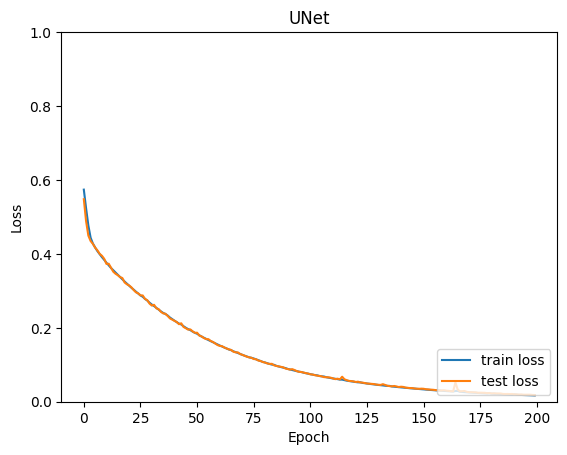

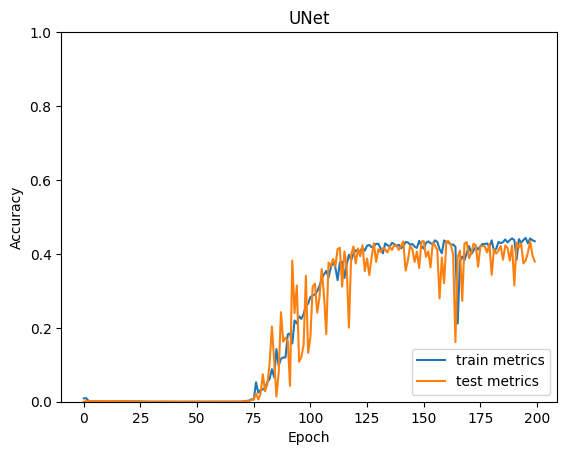

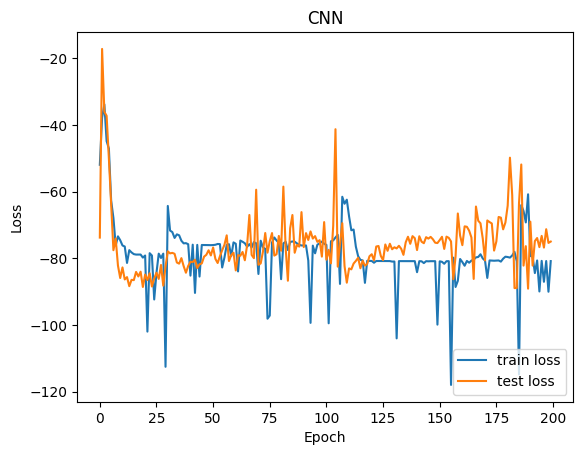

In [37]:
# UNet
plt.plot(u_results['t']['losses'], label='train loss')
plt.plot(u_results['v']['losses'], label='test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('UNet')
plt.show()

# UNet
plt.plot(u_results['t']['metrics'], label='train metrics')
plt.plot(u_results['v']['metrics'], label='test metrics')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('UNet')
plt.show()

# CNN
plt.plot(c_results['t']['losses'], label='train loss')
plt.plot(c_results['v']['losses'], label='test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('CNN')
plt.show()

#Experimenting

In [44]:
u_pred = predict(unet, test_loader)
c_pred = predict(cnn, test_loader)
u_pred.combine_first(c_pred)


# TODO: when making predictions using the CNN we must use UNet's output.

,image_paths,mask_paths,labels
names,,,
sarpol_007,NaN,output/sarpol_007.png,0.6607153
sarpol_010,NaN,output/sarpol_010.png,0.6607153
sarpol_011,NaN,output/sarpol_011.png,0.6607153
sarpol_016,NaN,output/sarpol_016.png,0.6607153
sarpol_019,NaN,output/sarpol_019.png,0.6607153
sarpol_020,NaN,output/sarpol_020.png,0.6607153
sarpol_025,NaN,output/sarpol_025.png,0.6607153
sarpol_026,NaN,output/sarpol_026.png,0.6607153
sarpol_031,NaN,output/sarpol_031.png,0.6607153
